In [1]:
import time
import threading
import logging
#import retro
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from sklearn.preprocessing import scale
import numpy as np
import cv2
import numpy as np
#import keyboard
import gym
import matplotlib.pylab as plt
from IPython.display import clear_output
#retro.data.list_games()

In [2]:
#obs, rew, done, info = env.step(env.action_space.sample())
#(224, 240, 3)
#MultiBinary(9)                          
class RAM_ANN():
  def __init__(self, action_space, state_space, frameskip, seed):
    self.seed = seed
    initializer1 = initializers.GlorotUniform (seed = self.seed+1)
    initializer2 = initializers.GlorotUniform (seed = self.seed+2)
    initializer3 = initializers.GlorotUniform (seed = self.seed+3)
    initializer4 = initializers.GlorotUniform (seed = self.seed+4)
    self.frameskip = frameskip
    self.action_space = len(action_space)
    num_actions = self.action_space
    #NN layers
    ram_input = layers.Input(shape=(state_space))
    #preprocessor = layers.experimental.preprocessing.Resizing(84, 84, interpolation='bilinear', name=None)(image_input)
    # Convolutions on the frames on the screen
    #data_format='channels_first'
    
    layer5 = layers.Dense(128, activation="relu", kernel_initializer = initializer1)(ram_input)
    layer6 = layers.Dense(512, activation="relu", kernel_initializer = initializer2)(layer5)
    layer7 = layers.Dense(128, activation="relu", kernel_initializer = initializer3)(layer6)
    action = layers.Dense(num_actions, activation="linear", kernel_initializer = initializer4)(layer7)

    #Define NN parameters.
    self.toymodel = keras.Model(inputs=ram_input, outputs=action)
    self.loss_fn = tf.keras.losses.Huber()
    self.optimizer = keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
    self.toymodel.compile(self.optimizer, self.loss_fn)

  def trainStep(self, sample_X, sample_Y):
    with tf.GradientTape() as tape:
      old_q = self.toymodel(sample_X, training=True)
      loss_value = self.loss_fn(sample_Y, old_q)
    grads = tape.gradient(loss_value, self.toymodel.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.toymodel.trainable_weights))
    return loss_value.numpy()

  def train(self, x_input, y_input, batchsize=64):
    loss_history = []
    dataset = tf.data.Dataset.from_tensor_slices((x_input, y_input))
    dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
    for steps, (x, y) in enumerate(dataset):
      loss_history.append(self.trainStep(x,y))
    return loss_history

  def forward(self, x_input):
    return self.toymodel(x_input)

class A3C():
  def __init__(self, action_space, state_space, frameskip, seed):
    self.seed = seed
    initializer1 = initializers.GlorotUniform (seed = self.seed+1)
    initializer2 = initializers.GlorotUniform (seed = self.seed+2)
    initializer3 = initializers.GlorotUniform (seed = self.seed+3)
    initializer4 = initializers.GlorotUniform (seed = self.seed+4)
    self.frameskip = frameskip
    self.action_space = len(action_space)
    self.num_actions = self.action_space
    self.state_space = state_space
    #NN layers
    ram_input = layers.Input(shape=(self.state_space))
    #preprocessor = layers.experimental.preprocessing.Resizing(84, 84, interpolation='bilinear', name=None)(image_input)
    # Convolutions on the frames on the screen
    #data_format='channels_first'
    layer5 = layers.Dense(256, activation="relu", kernel_initializer = initializer1)(ram_input)
    logaction = layers.Dense(self.num_actions, activation="linear", kernel_initializer = initializer2)(layer5)
    value = layers.Dense(1, activation="linear", kernel_initializer = initializer3)(layer5)

    #Define NN parameters.
    self.toymodel = keras.Model(inputs=ram_input, outputs=[logaction, value])
    self.loss_fn = tf.keras.losses.MeanSquaredError()
    self.optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    self.toymodel.compile(self.optimizer, self.loss_fn)

  def trainStep(self, sample_X, sample_Y):
    with tf.GradientTape() as tape:
      old_q = self.toymodel(sample_X, training=True)
      loss_value = self.loss_fn(sample_Y, old_q)
    grads = tape.gradient(loss_value, self.toymodel.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.toymodel.trainable_weights))
    return loss_value.numpy()

  def train(self, x_input, y_input, batchsize=64):
    loss_history = []
    dataset = tf.data.Dataset.from_tensor_slices((x_input, y_input))
    dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
    for steps, (x, y) in enumerate(dataset):
      loss_history.append(self.trainStep(x,y))
    return loss_history

  def forward(self, x_input):
    return self.toymodel(x_input)


class CONV_ANN():
  def __init__(self, action_space, ndim):
    self.action_space = len(action_space)
    num_actions = self.action_space
    #NN layers
    image_input = layers.Input(shape=(ndim,ndim,4))
    #preprocessor = layers.experimental.preprocessing.Resizing(84, 84, interpolation='bilinear', name=None)(image_input)
    # Convolutions on the frames on the screen
    #data_format='channels_first'
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(image_input)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Dense(512, activation="relu")(layer4)

    action = layers.Dense(num_actions, activation="linear")(layer5)

    #Define NN parameters.
    self.toymodel = keras.Model(inputs=image_input, outputs=action)
    self.loss_fn = tf.keras.losses.Huber()
    self.optimizer = keras.optimizers.Adam(learning_rate=0.0000625, epsilon=0.00015)
    self.toymodel.compile(self.optimizer, self.loss_fn)

  def trainStep(self, sample_X, sample_Y):
    with tf.GradientTape() as tape:
      old_q = self.toymodel(sample_X, training=True)
      loss_value = self.loss_fn(sample_Y, old_q)
    grads = tape.gradient(loss_value, self.toymodel.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.toymodel.trainable_weights))
    return loss_value.numpy()

  def train(self, x_input, y_input, batchsize=64):
    loss_history = []
    dataset = tf.data.Dataset.from_tensor_slices((x_input, y_input))
    dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
    for steps, (x, y) in enumerate(dataset):
      loss_history.append(self.trainStep(x,y))
    return loss_history

  def forward(self, x_input):
    return self.toymodel(x_input)

class LookAhead():
  def __init__(self, action_space):
    self.action_space = len(action_space)
    image_input = layers.Input(shape=(84,84,4))
    action_input = layers.Input(shape=self.action_space)
    #preprocessor = layers.experimental.preprocessing.Resizing(84, 84, interpolation='bilinear', name=None)(image_input)
    # Convolutions on the frames on the screen
    #data_format='channels_first'
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(image_input)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Concatenate(axis=1)([layer4, action_input])
    layer6 = layers.Dense(512, activation="relu")(layer5)
    layer7 = layers.Dense(3136, activation="relu")(layer6)
    layer8 = layers.Reshape((7, 7, 64))(layer7)
    layer9 = layers.Conv2DTranspose(64,3)(layer8)
    layer10 = layers.Conv2DTranspose(32,12)(layer9)
    layer11 = layers.Conv2DTranspose(4,65)(layer10)
    value_output = layers.Dense(1, activation='linear')(layer5)

    #Define NN parameters.
    toymodel = keras.Model(inputs=[image_input, action_input], outputs=[layer11, value_output])
    loss_fn = tf.keras.losses.Huber()
    optimizer = keras.optimizers.Adam(learning_rate=0.00025)
    toymodel.compile(optimizer, loss_fn)

  def trainStep(self, sample_X, sample_Y):
    with tf.GradientTape() as tape:
      old_q = self.toymodel(sample_X, training=True)
      loss_value = self.loss_fn(sample_Y, old_q)
    grads = tape.gradient(loss_value, self.toymodel.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.toymodel.trainable_weights))
    return loss_value.numpy()

  def train(self, x_input, y_input, batchsize=64):
    loss_history = []
    dataset = tf.data.Dataset.from_tensor_slices((x_input, y_input))
    dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
    for steps, (x, y) in enumerate(dataset):
      loss_history.append(self.trainStep(x,y))
    return loss_history

  def forward(self, x_input):
    return self.toymodel(x_input)

In [ ]:
#@title
class Agent():
    def __init__(self,runname, action_space, num_of_threads = 1, rom_name = 'CartPole-v1'):
        self.rom_name = rom_name
        self.eval_env = gym.make(self.rom_name)
        self.action_space = action_space
        self.num_of_threads = int(num_of_threads)
        # Every number of steps equal to the epoch length, evalulation a greedy run of the Q function.
        self.eval_epsilon = 0.05
        self.eval_reps = 10
        self.epoch_len = 50000
        
        self.steps_taken = 0 
        self.runname = runname
        self.len_of_episode = 10000

        #Set hyperparameters.
        self.epsilon = 1.0
        self.epsilon_max = 1.0
        self.epsilon_min = 0
        self.epsilon_lag = 50000
        self.annealing_time = 1000000
        self.gamma = 0.99
        self.max_memory_len = 1000000
        self.batch_size = 32
        self.steps_per_update = 4
        self.reward_scaler = 0.01
        self.target_update = 10000
        self.window = 25
        self.frameskip = 8 #Deprecated for the moment and needs updating
        
        #Initialize containers which will be prepared in thread_prep()
        self.loss_history = []
        self.action_history = []
        self.state_history= []
        self.next_state_history = []
        self.reward_history = []
        self.done_history = []
        self.episodic_return = []
        self.return_history = [] 
        self.env_container = []
        self.threads = []
        self.epsilon_schedule = []
        self.grads = []
        self.evaluations = []
        self.thread_prep()
        
        #Initialize target and behavior network.
        self.seed = 42
        self.behavior = CONV_ANN(self.action_space, 84) #RAM_ANN(self.action_space, 128, self.frameskip, self.seed)
        self.target = CONV_ANN(self.action_space, 84) #RAM_ANN(self.action_space, 128, self.frameskip,self.seed)
        self.A3C = A3C(self.action_space, 128, self.frameskip, self.seed)

    def clip_reward(self, reward):
        if reward > 0:
            return 1
        elif reward == 0:
            return 0
        else:
            return -1
    
    def popback(self, state_block, incoming_state):
        state_block.pop(0)
        state_block.append(incoming_state)
        return state_block

    def gradient_update(self, 
                        runname,
                        state_history, 
                        next_state_history,
                        rewards_history,
                        action_history,
                        loss_history,
                        model,
                        target_model,
                        gamma,
                        batch_size,
                        done_history,
                        action_space):
    
            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)
            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            next_state_sample = np.array([next_state_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])
            future_rewards = target_model.toymodel.predict(next_state_sample)
            updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards)
            updated_q_values = updated_q_values *(1-done_sample) - done_sample
            masks = tf.one_hot(action_sample, len(action_space))
            with tf.GradientTape() as tape:  
                q_values = model.toymodel(state_sample)
                q_actions = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                loss = model.loss_fn(updated_q_values, q_actions)
            loss_history = loss_history.append(loss)
            grads = tape.gradient(loss, model.toymodel.trainable_variables)
            model.toymodel.optimizer.apply_gradients(zip(grads, model.toymodel.trainable_variables))
                      
    def save_history(self,):   
        runname = self.runname
        np.save(runname + 'action_history',self.action_history)
        np.save(runname + 'state_history', self.state_history)
        np.save(runname + 'next_state_history', self.next_state_history)
        np.save(runname + 'reward_history', self.reward_history)
        np.save(runname + 'done_history', self.done_history)
        np.save(runname + 'return_history', self.episodic_return)
        np.save(runname + 'evaluations', self.evaluations)
        np.save(runname + 'loss_history', self.loss_history)
        self.behavior.toymodel.save(runname+'_behavior')
        self.target.toymodel.save(runname+'_target')

    def RGB_preprocess(self, action, env, frameskips):
        state_output = []
        reward = 0
        for i in range(frameskips):
            s, r, d, info = env.step(action)
            reward += r
            s = cv2.cvtColor(s, cv2.COLOR_RGB2GRAY)
            s = cv2.resize(s, (84, 84), interpolation=cv2.INTER_AREA)
            state_output.append(s/255.0)
        #return np.max(np.dstack(state_output), axis=2), reward, d, info #For max stacking
        return np.dstack(state_output).astype('float16'), reward, d, info #For frame stacking

    def preprocess(self, state):
        #return [state[0]/4.8, state[1], state[2]/0.418, state[3]]
        return state/255.0

    def memory_manager(self,array, mem_size):
        num_delete = len(array) - mem_size
        if num_delete < 0:
            None
        else:
            del array[:num_delete]
            
    def piecewise_epsilon(self, steps_taken, lag, annealingtime, ep_min, ep_max): #returns epsilon
        anneal_slope= (ep_min-ep_max)/(lag+annealingtime-lag)
        if steps_taken < lag: return ep_max
        if (steps_taken >= lag) and (steps_taken < (lag+annealingtime)): return anneal_slope*steps_taken+(ep_max-anneal_slope*lag)
        else: return ep_min

    def sliding_average(self, array, n):
        output = []
        for i in range(len(array)):
            try:
                output.append(np.average(array[i:i+n]))
            except IndexError:
                break
        return output
    
    def thread_prep(self):
        self.loss_history = [[] for i in range(self.num_of_threads)]
        self.action_history = [[] for i in range(self.num_of_threads)]
        self.state_history = [[] for i in range(self.num_of_threads)]
        self.next_state_history = [[] for i in range(self.num_of_threads)]
        self.reward_history = [[] for i in range(self.num_of_threads)]
        self.done_history = [[] for i in range(self.num_of_threads)]
        self.episodic_return = [[] for i in range(self.num_of_threads)]
        self.return_history = [[] for i in range(self.num_of_threads)]
        self.env_container = [gym.make(self.rom_name) for i in range(self.num_of_threads)]
        self.steps_taken = [0 for i in range(self.num_of_threads)]
        self.evaluations = [[] for i in range(self.num_of_threads)]
        self.epsilon_schedule = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
        
        
    def agent_thread(self, thread_num, num_training_steps, seed=42):
        logging.info("Thread %s: starting", thread_num)
        env = self.env_container[thread_num]
        #self.env_container[thread_num].seed(seed)
        self.RGB_episode(num_training_steps, env, thread_num, epsilon)
        self.episode(num_training_steps*self.steps_per_update, self.env_container[thread_num], thread_num, self.epsilon_schedule[thread_num])
        logging.info("Thread %s: finishing", thread_num)
     
    def start_threads(self, num_training_steps=1):
        format = "%(asctime)s: %(message)s"
        logging.basicConfig(format=format, level=logging.INFO, datefmt="%H:%M:%S")
        grads = []
        for i in range(self.num_of_threads):
            logging.info("Main    : create and start thread %d.", i)
            x = threading.Thread(target=self.agent_thread, args=(i, num_training_steps))
            self.threads.append(x)
            x.start()
                
        while len(self.state_history[0]) < num_training_steps:
            self.plot_data()
            time.sleep(10)
                            
        for j in self.threads:
            j.join()

        self.plot_data()
        
    def plot_data(self,):
        clear_output()
        plt.figure(figsize=(10,2))
        for i in range(self.num_of_threads):
            plt.plot(self.episodic_return[i], label='Thread ' + str(i))
        plt.xlabel('Episode')
        plt.ylabel('Return')
        plt.legend(loc=7)
        plt.show()
        
        plt.figure(figsize=(10,2))
        for i in range(self.num_of_threads):
            plt.plot(self.sliding_average(self.episodic_return[i], self.window), label='Thread '+str(i))
        plt.xlabel('Episode')
        plt.ylabel(str(self.window)+'-averaged Return')
        plt.legend(loc=7)
        plt.show()

        plt.figure(figsize=(10,2))
        for i in range(self.num_of_threads):
            plt.plot(self.evaluations[i], label='Thread '+str(i))
        plt.xlabel('Episode')
        plt.ylabel('Evaluation Return')
        plt.legend(loc=7)
        plt.show()
        
        plt.figure(figsize=(10,2))
        for i in range(self.num_of_threads):
            plt.plot(self.loss_history[i], label='Thread '+str(i))
        plt.xlabel('Training Step')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.legend(loc=7)
        plt.show()

        plt.figure(figsize=(10,2))
        for i in range(self.num_of_threads):
            Y = [self.piecewise_epsilon(i, self.epsilon_lag, self.annealing_time, self.epsilon_min, self.epsilon_max) for i in np.arange(self.steps_taken[i])]
            plt.plot(Y, label='Thread '+str(i))
        plt.xlabel('Steps taken')
        plt.ylabel('Epsilon')
        plt.legend(loc=7)
        plt.show()
        
    def evaluate_NN(self, env, epsilon, replicates, thread_num):
        av_returns = []
        for i in range(replicates):
            s = env.reset()
            s, episode_return, done, info = self.RGB_preprocess(1, env, self.frameskip)
            episode_return = 0
            done = False
            while not done:
                if np.random.random() < epsilon:
                    a = np.random.choice(np.arange(len(self.action_space)))
                else: 
                    a_probs = self.behavior.toymodel(np.expand_dims(s,0), training=False)
                    a = tf.argmax(a_probs[0]).numpy()
                s, reward, done, info = self.RGB_preprocess(a, env, self.frameskip)
                episode_return += reward
            av_returns.append(episode_return)
        self.evaluations[thread_num].append(np.average(av_returns))
        
    def RGB_episode(self, num_training_steps, env, thread_num, epsilon):    #Double Deep Q
        #np.random.seed(self.seed)
        epsilon = self.piecewise_epsilon(self.steps_taken[thread_num], self.epsilon_lag, self.annealing_time, self.epsilon_min, self.epsilon_max)
        while self.steps_taken[thread_num] < num_training_steps:
            env.seed(self.seed)
            if len(self.episodic_return[thread_num])%25==0: self.plot_data()
            epi_return = 0 
            lives = 5     #5 for Breakout, 3 for Space Invaders
            env.reset()
            s, reward, done, info = self.RGB_preprocess(1, env, self.frameskip)
            #Enter the loop.
            while self.steps_taken[thread_num] < num_training_steps:
                if self.steps_taken[thread_num]%self.epoch_len==0: 
                    self.evaluate_NN(self.eval_env, self.eval_epsilon, self.eval_reps, thread_num)
                    self.save_history()
                #Break the loop if the maximum number of training examples have been reached.
                if self.steps_taken[thread_num] >= num_training_steps:
                    break
                #Choose an action from according to epsilson-greedy policy.  
                if np.random.random() < epsilon:
                    a = np.random.choice(np.arange(len(self.action_space)))
                else: 
                    a_probs = self.behavior.toymodel(np.expand_dims(s,0), training=False)
                    a = tf.argmax(a_probs[0]).numpy()
                s_prime, reward, done, info = self.RGB_preprocess(self.action_space[a], env, self.frameskip)
                epi_return += reward
              
                #Restart when the end of the episode is reached.  
                if done:                                                                              #FUNCTIONIZE!
                    #Set the last frame to -1 to discourage dying.                                             
                    self.done_history[thread_num][-1] = True 
                    #self.reward_history[thread_num][-1] = -1
                    break
                if not (int(info['ale.lives']) == lives):                                         
                    self.done_history[thread_num][-1] = True 
                    #self.reward_history[thread_num][-1] = -1
                    lives = int(info['ale.lives'])
                    #print ('Episode finished in ', step_in_episode, 'steps.')
                    break                                  
                #Monitor the the number of lives from the environemtnt. If the number of lives is reduced, then the player has died. Reset the level.  FUNCTIONIZE!                

                #Save to history
                self.reward_history[thread_num].append(self.clip_reward(reward)*self.reward_scaler)
                self.state_history[thread_num].append(s)
                self.action_history[thread_num].append(a)
                self.next_state_history[thread_num].append(s_prime)
                self.done_history[thread_num].append(done)
                 
                if self.steps_taken[thread_num]>self.batch_size and self.steps_taken[thread_num]%self.steps_per_update==0:
                      self.gradient_update(self.runname,
                                        self.state_history[thread_num], 
                                        self.next_state_history[thread_num],
                                        self.reward_history[thread_num],
                                        self.action_history[thread_num],
                                        self.loss_history[thread_num],
                                        self.behavior,
                                        self.target,
                                        self.gamma,
                                        self.batch_size,
                                        self.done_history[thread_num],
                                        self.action_space) 
                        
                        
                if self.steps_taken[thread_num]%self.target_update==0:
                    self.target.toymodel.set_weights(self.behavior.toymodel.get_weights()) 

                s = s_prime

                self.steps_taken[thread_num] += 1
                self.memory_manager(self.action_history[thread_num], self.max_memory_len)
                self.memory_manager(self.state_history[thread_num], self.max_memory_len)
                self.memory_manager(self.next_state_history[thread_num], self.max_memory_len)
                self.memory_manager(self.reward_history[thread_num], self.max_memory_len)
                self.memory_manager(self.done_history[thread_num], self.max_memory_len)
            self.episodic_return[thread_num].append(epi_return)
        env.close()
        #self.behavior.toymodel.save('120228_Breakout')
                               
    def A3C_episode(self, num_training_steps, env, thread_num):    #Double Deep Q
        #np.random.seed(self.seed)
        while self.steps_taken[thread_num] < num_training_steps:
            env.seed(self.seed)
            epi_return = 0 
            steps = 0
            lives = 5     #5 for Breakout, 3 for Space Invaders
            s = self.preprocess(env.reset())
            s, reward, done, info = env.step(1)
            done = False
            #Enter the loop.
            if len(self.episodic_return[thread_num])%25==0: self.plot_data()
            while self.steps_taken[thread_num] < num_training_steps:

                #Break the loop if the maximum number of training examples have been reached.
                if self.steps_taken[thread_num] >= num_training_steps:
                    break
                #Choose an action from according to epsilson-greedy policy.  
                a_probs, value = self.A3C.toymodel(np.expand_dims(s,0), training=False)
                a = np.random.choice(self.action_space,p=tf.nn.softmax(a_probs[0]).numpy())
                
                s_prime, reward, done, info = env.step(self.action_space[a])
                s_prime = self.preprocess(s_prime)
                epi_return += reward

                #Restart when the end of the episode is reached.  
                if done:                                                                              #FUNCTIONIZE!
                    #Set the last frame to -1 to discourage dying.                                             
                    self.done_history[thread_num][-1] = True 
                    self.reward_history[thread_num][-1] = -1
                    self.episodic_return[thread_num].append(epi_return)
                    break
                if not (int(info['ale.lives']) == lives):                                         
                    self.done_history[thread_num][-1] = True 
                    self.reward_history[thread_num][-1] = -1
                    self.episodic_return[thread_num].append(epi_return)
                    lives = int(info['ale.lives'])
                    #print ('Episode finished in ', step_in_episode, 'steps.')
                    break               
                                
                #Monitor the the number of lives from the environemtnt. If the number of lives is reduced, then the player has died. Reset the level.  FUNCTIONIZE!                

                #Save to history
                self.reward_history[thread_num].append(reward*self.reward_scaler)
                self.state_history[thread_num].append(s)
                self.action_history[thread_num].append(a)
                self.next_state_history[thread_num].append(s_prime)
                self.done_history[thread_num].append(done)
                 
                if self.steps_taken[thread_num]>self.batch_size and self.steps_taken[thread_num]%self.steps_per_update==0:
                    #Enable option for experience replay by random sampling or total memory sampling.
                    # Get indices of samples for replay buffers
                    indices = np.random.choice(range(len(self.done_history[thread_num])), size=self.batch_size)
                    # Using list comprehension to sample from replay buffer
                    state_sample = np.array([self.state_history[thread_num][i] for i in indices])
                    next_state_sample = np.array([self.next_state_history[thread_num][i] for i in indices])
                    rewards_sample = [self.reward_history[thread_num][i] for i in indices]
                    action_sample = [self.action_history[thread_num][i] for i in indices]
                    done_sample = tf.convert_to_tensor([float(self.done_history[thread_num][i]) for i in indices])
                                        
                    with tf.GradientTape() as tape:
                        future_rewards = self.A3C.toymodel(next_state_sample)[1][:,0]
                        future_rewards = future_rewards *(1-done_sample) - done_sample                    
                        discounted_reward = rewards_sample + self.gamma * future_rewards   
                        logits, values = self.A3C.toymodel(state_sample)   
                        values = values[:,0]
                        advantage = discounted_reward-values
                        masks = tf.one_hot(action_sample, len(self.action_space))
                        policy = tf.nn.softmax(logits)
                        entropy = tf.reduce_sum(policy * tf.math.log(policy+1e-20),axis=1)
                        value_loss = advantage**2
                        policy_loss = tf.nn.softmax_cross_entropy_with_logits(labels=masks, logits=logits)
                        policy_loss *= tf.stop_gradient(advantage)
                        policy_loss -= 0.0005 * entropy
                        total_loss = (0.5 * value_loss + policy_loss)
                    loss_history = self.loss_history[thread_num].append(np.mean(total_loss))
                    # Calculate local gradients
                    grads = tape.gradient(total_loss, self.A3C.toymodel.trainable_weights)
                    # Push local gradients to global model
                    self.A3C.toymodel.optimizer.apply_gradients(zip(grads, self.A3C.toymodel.trainable_weights))
                    steps += 1                 
                s = s_prime

                self.steps_taken[thread_num] += 1
                self.memory_manager(self.action_history[thread_num], self.max_memory_len)
                self.memory_manager(self.state_history[thread_num], self.max_memory_len)
                self.memory_manager(self.next_state_history[thread_num], self.max_memory_len)
                self.memory_manager(self.reward_history[thread_num], self.max_memory_len)
                self.memory_manager(self.done_history[thread_num], self.max_memory_len)          
        env.close()


        #self.behavior.toymodel.save('120228_Breakout')

In [ ]:
atari_action_space = np.arange(4)
env = gym.make("BreakoutDeterministic-v4")
agent = Agent('210405_1', atari_action_space, num_of_threads = 1, rom_name="BreakoutDeterministic-v4")
agent.epsilon = 1.0
agent.epsilon_max = 1.0
agent.epsilon_min = 0.1
agent.epsilon_lag = 10000
agent.annealing_time = 1000000
agent.len_of_episode = 10000
agent.gamma = 0.99
agent.max_memory_len = 100000
agent.batch_size = 32
agent.steps_per_update = 4
agent.reward_scaler = 1
agent.target_update = 50000
agent.epsilon_schedule = [0.05, 0.2, 0.4, 0.6, 0.8, 1.0]
agent.frameskip = 4

#Evaluation parms
agent.eval_epsilon = 0.05
agent.eval_reps = 10
agent.epoch_len = 5000
#agent.episode(10000000, env1)
#LR is 0.0000625
agent.behavior.toymodel.summary()

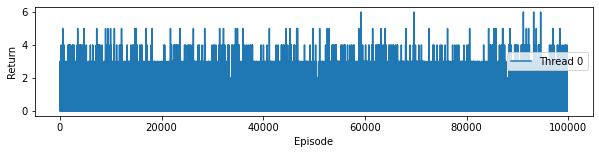

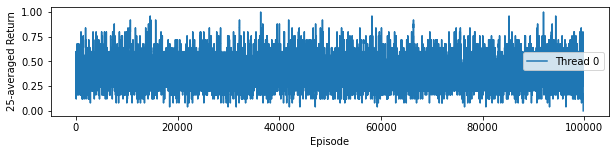

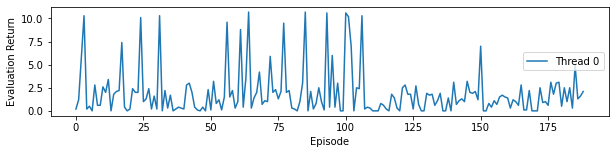

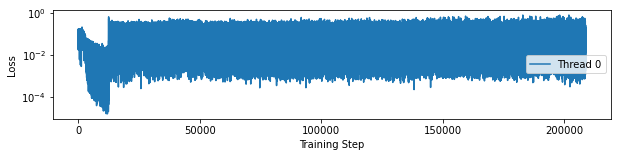

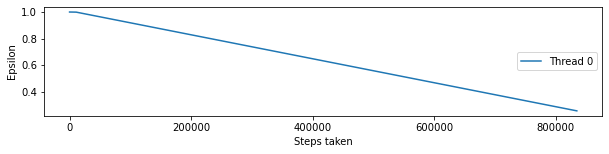

In [ ]:
agent.RGB_episode(100000000, env, 0, 0.05)

In [ ]:
# Get indices of samples for replay buffers
indices = np.random.choice(range(len(agent.done_history[0])), size=batch_size)
# Using list comprehension to sample from replay buffer
state_sample = np.array([agent.state_history[0][i] for i in indices])
next_state_sample = np.array([agent.next_state_history[0][i] for i in indices])
rewards_sample = [agent.reward_history[0][i] for i in indices]
action_sample = [action_history[i] for i in indices]
done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])
future_rewards = target_model.toymodel.predict(next_state_sample)
updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards)
updated_q_values = updated_q_values *(1-done_sample) - done_sample
masks = tf.one_hot(action_sample, len(action_space))
with tf.GradientTape() as tape:  
    q_values = model.toymodel(state_sample)
    q_actions = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
    loss = model.loss_fn(updated_q_values, q_actions)
loss_history = loss_history.append(loss)
grads = tape.gradient(loss, model.toymodel.trainable_variables)
model.toymodel.optimizer.apply_gradients(zip(grads, model.toymodel.trainable_variables))